In [1]:
import random
import pickle
import math
import traceback
import os
import tensorflow as tf 
import numpy as np
from tensorflow import keras
input_dir = "../data/semantic-segmentation/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train" #CHANGE THE PATHS!!!
target_dir = "../data/semantic-segmentation/cityscapes/gtFine_trainvaltest/gtFine/train" #CHANGE THE PATHS!!!
img_size = (256, 256)
num_classes = 20
batch_size = 32
from cityscapes import Cityscapes,get_img_paths
input_img_paths,target_img_paths = get_img_paths(input_dir,target_dir)
print("Number of samples:", len(input_img_paths))   
# Split our img paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Cityscapes(
  batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Cityscapes(batch_size, img_size, val_input_img_paths, val_target_img_paths)
dataset = (train_gen,val_gen)
input_shape = (256,256,3)
TRAIN_WITH_GEN = True
TRAIN_WITH_LOGITS = True
n_classes = 20

from city_pss import City_PSS
NUM_SPLITS = 5
city_pss_gen = City_PSS(input_dir,target_dir,img_size,num_classes,batch_size,NUM_SPLITS)
ds_table = city_pss_gen.backup_table.copy()
for cl in range(num_classes):
        ds_table[str(cl)] = ds_table.apply(lambda row: city_pss_gen.count_class(row[1],cl,img_size), axis=1)
cls_pixels = ds_table[[str(i) for i in range(20)]].sum()
all_pixels = 20*input_shape[1]*input_shape[1]*len(ds_table)
class_weights = dict()
for i_cl, cl_pixels in enumerate(cls_pixels):
    class_weights[i_cl] = all_pixels/(n_classes*cl_pixels)

    
CW = class_weights
CW = [math.log(v) for v in class_weights.values()]

sample_weights = np.zeros((input_shape[1],input_shape[1], 20))
for key in class_weights:
    sample_weights[:, key] += class_weights[key]
    
SW = sample_weights
    
import tensorflow as tf

import tensorflow as tf

def DatasetFromSequenceClass(sequenceClass, stepsPerEpoch, nEpochs, batchSize, dims=[512,512,3], n_classes=2, data_type=tf.float32, label_type=tf.uint8):
    # eager execution wrapper
    def DatasetFromSequenceClassEagerContext(func):
        def DatasetFromSequenceClassEagerContextWrapper(batchIndexTensor):
            # Use a tf.py_function to prevent auto-graph from compiling the method
            tensors = tf.py_function(
                func,
                inp=[batchIndexTensor],
                Tout=[data_type, label_type]
            )
            # set the shape of the tensors - assuming channels last
            tensors[0].set_shape([batchSize, dims[0], dims[1], dims[2]])   # [samples, height, width, nChannels]
            tensors[1].set_shape([batchSize, dims[0], dims[1], n_classes]) # [samples, height, width, nClasses for one hot]
            return tensors
        return DatasetFromSequenceClassEagerContextWrapper
    
    @DatasetFromSequenceClassEagerContext
    def LoadBatchFromSequenceClass(batchIndexTensor):
        batchIndex = batchIndexTensor.numpy()
        zeroBatch = batchIndex % stepsPerEpoch
        data, labels = sequenceClass[zeroBatch]
        return tf.convert_to_tensor(data), tf.convert_to_tensor(labels)
    
    dataset = tf.data.Dataset.range(stepsPerEpoch*nEpochs)
    return dataset.map(LoadBatchFromSequenceClass, num_parallel_calls=tf.data.experimental.AUTOTUNE)

from tensorflow.keras.layers.experimental import preprocessing 
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

nEpochs = 1

BUFFER_SIZE = 100
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

from matplotlib import pyplot as plt
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
training = DatasetFromSequenceClass(train_gen, len(train_gen), nEpochs, batch_size, dims=input_shape, n_classes=n_classes)
validation = DatasetFromSequenceClass(val_gen, len(val_gen), nEpochs, batch_size, dims=input_shape, n_classes=n_classes)

training = training.prefetch(buffer_size=tf.data.AUTOTUNE).cache().repeat()
validation = validation.repeat().cache()

def add_sample_weights(image, label):
    class_weights = tf.constant(CW)
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

def show_predictions(dataset=None, num=3):
    for image, mask in validation.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
        
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(epoch%5==0 or epoch>18):
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
from tensorflow.keras.callbacks import ReduceLROnPlateau        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01, verbose=1)




Number of samples: 2975
Number of samples: 2975


In [2]:
from create_models import create_unet

In [3]:
model= create_unet(classes=20)

In [4]:
pss_training = []
pss_splits = city_pss_gen.getSplits()
for pss_split in pss_splits:
    
    training_temp = DatasetFromSequenceClass(pss_split, len(pss_split), nEpochs, batch_size, dims=input_shape, n_classes=n_classes)
    training_temp = training.prefetch(buffer_size=tf.data.AUTOTUNE).cache().repeat()
    pss_training.append(training)

In [ ]:
import random
print(random.randint(0,100))
from tqdm import tqdm
for i in tqdm(range(10)):
    print(random.randint(0,100))

In [5]:
seeds = [93,36,99,4,62]

In [6]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
no_pss_history = []

In [17]:
from tqdm import tqdm

In [18]:
# 'mobilenet','resnet18','vgg16', 'resnet34'
#1:50 + 
for seed in seeds:
    split_history = dict()
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    split_history = dict()
    for arch in ['efficientnetb0','mobilenet','resnet18','vgg16', 'inceptionresnetv2','inceptionv3']:
        split_history[arch] = dict()
        model = sm.Unet(arch,input_shape=input_shape, classes=20, activation='softmax', encoder_weights=None)
        model.compile(loss='categorical_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'])
        for i in tqdm(range(NUM_SPLITS)):
            history = model.fit(training,epochs=5, steps_per_epoch=len(train_gen), validation_data=validation, validation_steps=len(val_gen), verbose=0)
            if(i==0):
                split_history[arch].update(history.history)
            else:
                for k in split_history[arch]:
                    split_history[arch][k] = split_history[arch][k]+history.history[k]
        del model
    no_pss_history.append(split_history)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:02<00:00, 96.57s/it]


In [46]:
pss_history_backup = pss_history.copy()
no_pss_history_backup = no_pss_history.copy()

In [ ]:
f

In [19]:
pss_history = []

In [21]:
# pss_history = []
# 36
for seed in tqdm(seeds):
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    split_history = dict()
    for arch in ['efficientnetb0','inceptionresnetv2','inceptionv3' ]:
        split_history[arch] = dict()
        model = sm.Unet(arch,input_shape=input_shape, classes=20, activation='softmax', encoder_weights=None)
        model.compile(loss='categorical_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'])
        for i,split in enumerate(pss_training):
            history = model.fit(split,epochs=5, steps_per_epoch=int((len(train_gen)/NUM_SPLITS)+1), validation_data=validation, validation_steps=len(val_gen), verbose=0)
            if(i==0):
                split_history[arch].update(history.history)
            else:
                for k in split_history[arch]:
                    split_history[arch][k] = split_history[arch][k]+history.history[k]
        del model
    pss_history.append(split_history)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:39:09<00:00, 1189.92s/it]


In [44]:
for arch in ['resnet34']:
    print(arch)
    print('pss',pss_history[7][arch]['val_loss'][-1]) # 45, 1.4, 57
    print('no-pss',no_pss_history[7][arch]['val_loss'][-1]) #40 , 44, 39

resnet34
pss 0.4512319564819336
no-pss 0.35489943623542786


In [23]:
import pickle
with open('pss-6.pkl','wb') as f:
    pickle.dump((no_pss_history,pss_history),f)

In [37]:
full_pss = pss_history.copy()
full_no_pss = no_pss_history.copy()

In [68]:
arches =  {'efficientnetb0':[], 'inceptionresnetv2':[],'inceptionv3':[]}
f_val_loss_pss = {'efficientnetb0':[],'inceptionresnetv2':[],'inceptionv3':[]}
for arch in arches:
    temp =  []
    for run in full_pss:
        temp.append(max(run[arch]['val_accuracy']))
    f_val_loss_pss[arch] = temp

In [69]:
arches =   {'efficientnetb0':[],'inceptionresnetv2':[],'inceptionv3':[]}
f_val_loss_no_pss = {'efficientnetb0':[],'inceptionresnetv2':[],'inceptionv3':[]}
for arch in arches:
    temp =  []
    for run in full_no_pss:
        temp.append(max(run[arch]['val_accuracy']))
    f_val_loss_no_pss[arch] = temp

In [70]:
import pandas as pd
df1 = pd.DataFrame.from_dict(f_val_loss_no_pss)
df2 = pd.DataFrame.from_dict(f_val_loss_pss)

In [99]:
df2[['inceptionv3','resnet18','efficientnetb0']].describe()

,inceptionv3,resnet18,efficientnetb0
count,5.000000,5.000000,5.000000
mean,0.851716,0.851233,0.850326
std,0.009355,0.004319,0.006284
min,0.836836,0.844640,0.844627
25%,0.850424,0.849695,0.845907
50%,0.851999,0.852496,0.848310
75%,0.859097,0.853332,0.852631
max,0.860225,0.856005,0.860154


In [100]:
df1[['efficientnetb0','resnet18','inceptionv3']]

,efficientnetb0,resnet18,inceptionv3
0,0.883365,0.889712,0.893343
1,0.882359,0.893884,0.897835
2,0.878411,0.890373,0.898163
3,0.876944,0.890319,0.896241
4,0.881279,0.888519,0.898742


   Location    architecture     value
0  With PSS  efficientnetb0  0.852631
1  With PSS  efficientnetb0  0.860154
2  With PSS  efficientnetb0  0.844627
3  With PSS  efficientnetb0  0.845907
4  With PSS  efficientnetb0  0.848310


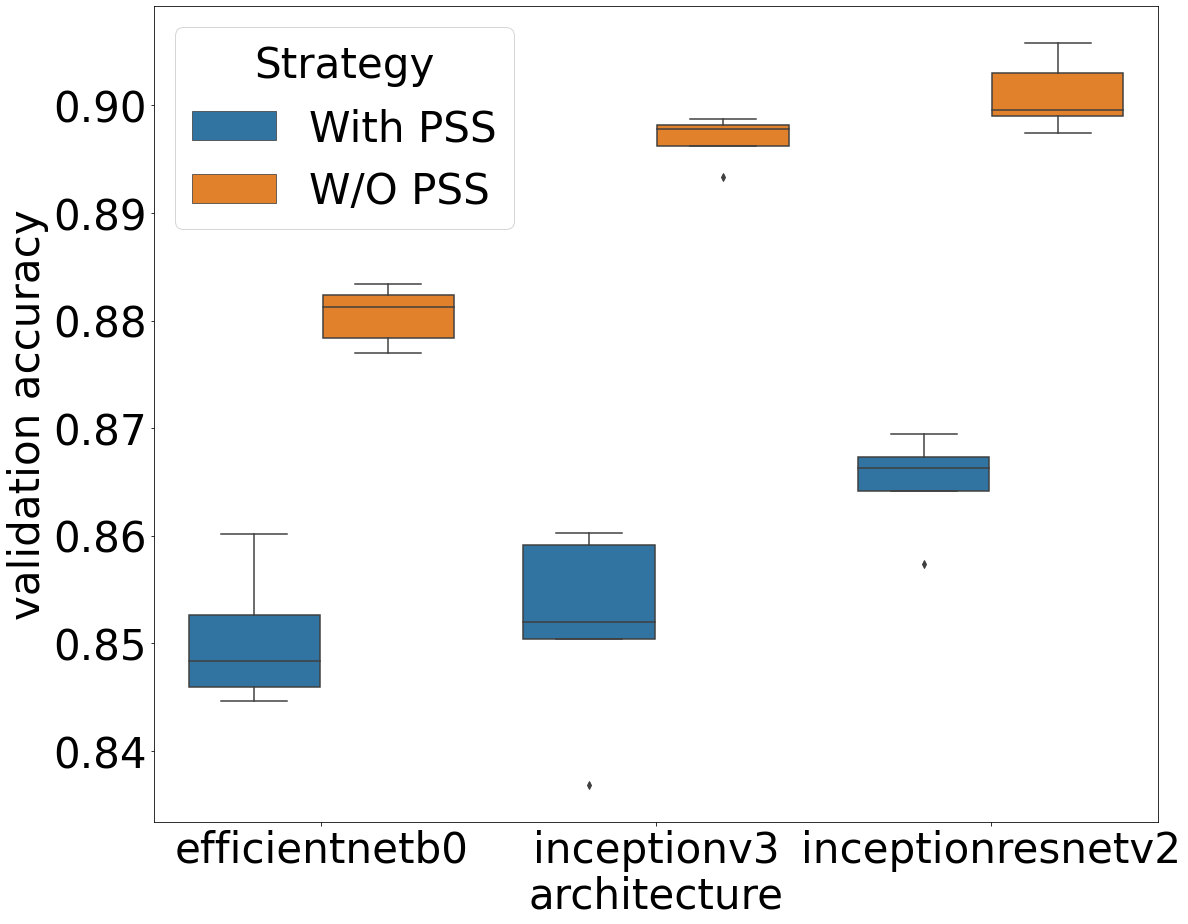

In [87]:
# ds_table.describe().loc[['mean','std','min','max']].plot(kind='box', figsize=[16,8], ylim=(0,18000))
# data1 = ds_table.describe().loc[['mean','std','min','max']].assign(Location='Original')
data1 = df2[['efficientnetb0', 'inceptionv3', 'inceptionresnetv2']].assign(Location='With PSS')
data2 = df1[['efficientnetb0', 'inceptionv3', 'inceptionresnetv2']].assign(Location='W/O PSS')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
cdf = pd.concat([data1, data2])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['architecture'])
print(mdf.head())
mdf = mdf.rename(columns={"Location": "Strategy", "value":"validation accuracy"})
ax = sns.boxplot(x="architecture", y="validation accuracy", hue="Strategy", data=mdf, )  
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# plt.rcParams = params
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 27}
# plt.rcParams['font.size']= 42
plt.rcParams['figure.figsize'] =  18, 15

# plt.rcParams['dpi']= 210
plt.savefig('fig-pss-proof.png',bbox_inches='tight')

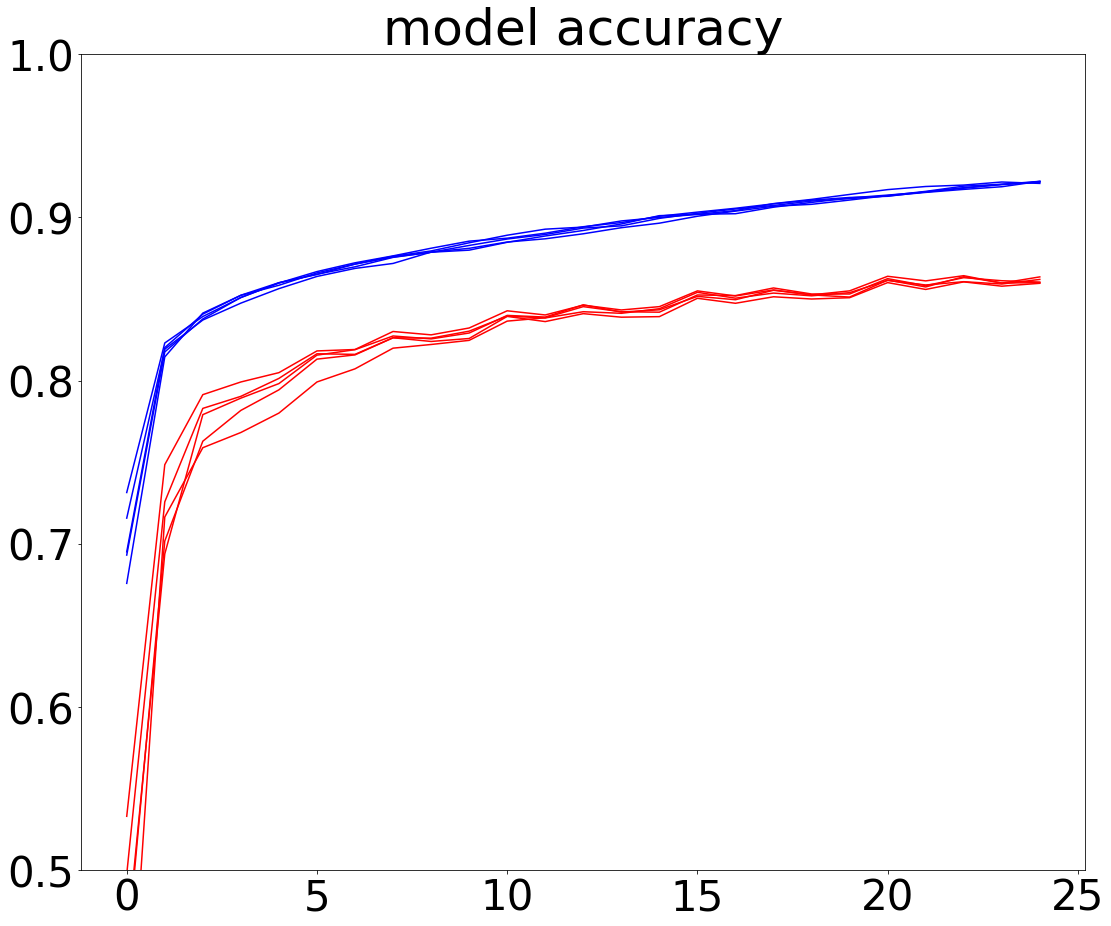

In [98]:
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
for res in full_pss:
    plt.plot(res['mobilenet']['accuracy'], color='r')
for res in full_no_pss:
    plt.plot(res['mobilenet']['accuracy'], color='b')
plt.title('model accuracy')
plt.ylim(0.5,1)
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.rcParams['figure.figsize'] =  40, 30
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
[res['val_loss'] for res in no_pss_history]

[[32.85463333129883,
  4.819709300994873,
  0.8391370177268982,
  0.7633433938026428,
  0.5837811231613159,
  0.5236365795135498,
  0.8494641184806824,
  0.4205717146396637,
  0.39812663197517395,
  0.44984376430511475,
  0.40049102902412415,
  0.45368337631225586,
  0.35857120156288147,
  0.42634811997413635,
  0.37295857071876526,
  0.38591107726097107,
  0.34494391083717346,
  0.3605477809906006,
  0.3803598880767822,
  0.3248794376850128]]